In [1]:
from Eof_functions import *

path = 'C:\\Users\\ratynski\\Documents\\Python_Projects\\stratocu_waves-main\\DATA\\2022_09_06\\'
os.chdir(path)
files = glob.glob('*.png')

#for each image, create a frame_letter variable that will be used to store the imread image

frame_a = tools.imread(path + files[0])
frame_b = tools.imread(path + files[1])
frame_c = tools.imread(path + files[2])
frame_d = tools.imread(path + files[3])
frame_e = tools.imread(path + files[4])
frame_f = tools.imread(path + files[5])
frame_g = tools.imread(path + files[6])
frame_h = tools.imread(path + files[7])
frame_i = tools.imread(path + files[8])
frame_j = tools.imread(path + files[9])

frames = np.array([frame_a, frame_b, frame_c, frame_d, frame_e, frame_f, frame_g, frame_h, frame_i, frame_j])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.fft import fftn, fftshift
from scipy.optimize import curve_fit

def bisinusoidal_func(theta, A1, phi1, A2, phi2, C):
    return A1 * np.sin(2 * theta + phi1) + A2 * np.cos(2 * theta + phi2) + C

def bi_sinezoidal_fitting(theta, data):
    # Initial guess for the parameters: A1, phi1, A2, phi2, C
    initial_guess = [1, 0, 1, 0, 0]
    params, _ = curve_fit(bisinusoidal_func, theta, data, p0=initial_guess)
    return params


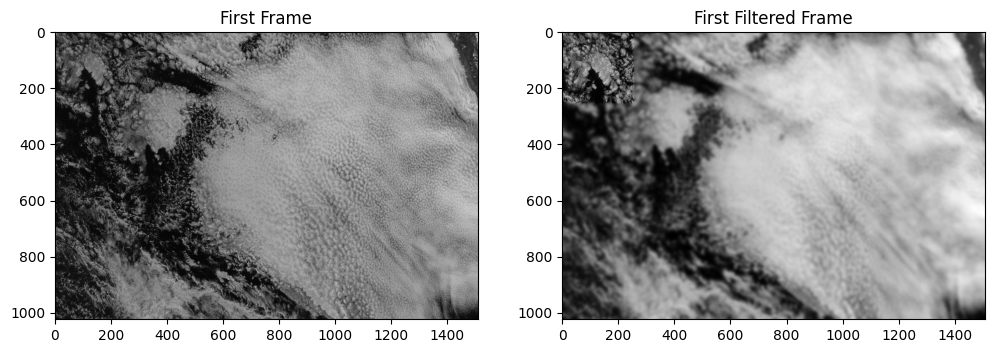

In [23]:
frame=frames[0,:,:]

data_shape = frame.shape
all_directions = []
all_amplitudes = []

square_size=128*2
sigma=5
overlap = 0.5
step_size = int(square_size * (1 - overlap))

kl_cutoff_inf=0.01
kl_cutoff_sup=0.1 
wavenumber_step=0.01
wavenumber_values = np.arange(kl_cutoff_inf, kl_cutoff_sup, wavenumber_step)

i,j=1,1

# Apply Gaussian filter to the entire frame, excluding the current square
blurred_frame = gaussian_filter(frame, sigma=sigma)
blurred_frame[i:i+square_size, j:j+square_size] = frame[i:i+square_size, j:j+square_size]
            
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(frames[0], cmap='gray')
axs[0].set_title("First Frame")
axs[1].imshow(blurred_frame, cmap='gray')
axs[1].set_title("First Filtered Frame")
plt.show()

In [24]:
# Perform FFT on the entire frame
fft_data = fftn(blurred_frame)
fft_data = fftshift(fft_data)

# Calculate kl unitlessly for each pixel
k = fftshift(np.fft.fftfreq(data_shape[1], d=1/data_shape[1]))
l = fftshift(np.fft.fftfreq(data_shape[0], d=1/data_shape[0]))
k, l = np.meshgrid(k, l)

k = k / data_shape[1]
l = l / data_shape[0]

radius = np.sqrt(k**2 + l**2)
theta = np.arctan2(l, k)
amplitude = np.abs(fft_data)

directions = []
amplitudes = []

for wavenumber in wavenumber_values:
    mask = (radius > (wavenumber - wavenumber_step/2)) & (radius < (wavenumber + wavenumber_step/2))
    if np.any(mask):
        # min_amplitude = np.min(amplitude[mask])
        # amplitude[mask] -= min_amplitude
        extracted_data = amplitude[mask]
        theta_flat = theta[mask]
        
        # Perform bi-sinezoidal fitting
        params = bi_sinezoidal_fitting(theta_flat, extracted_data)
        direction = params[1]  # Use phase shift phi1 as the direction
        amplitude_val = np.sqrt(params[0]**2 + params[2]**2)  # Combine A1 and A2 for overall amplitude
        
        # Store direction and amplitude data
        directions.append(direction)
        amplitudes.append(amplitude_val)

all_directions.append(directions)
all_amplitudes.append(amplitudes)




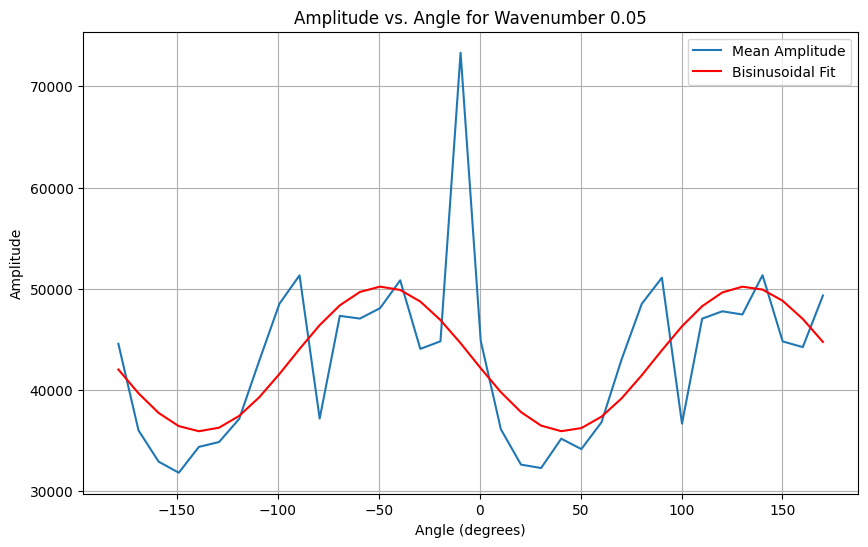

In [25]:
# Just a code to visualize the amplitude vs. angle for a specific wavenumber value

wavenumber_value = 0.05 

# Extract data for the specified wavenumber value
mask = (radius > (wavenumber_value - wavenumber_step/2)) & (radius < (wavenumber_value + wavenumber_step/2))
extracted_data = amplitude[mask]
theta_flat = theta[mask]

# Create theta bins
num_bins = 36  # 10 degrees each bin
theta_bins = np.linspace(np.min(theta_flat), np.max(theta_flat), num_bins + 1)
mean_amplitude = np.zeros(num_bins)

for j in range(num_bins):
    in_bin = (theta_flat >= theta_bins[j]) & (theta_flat < theta_bins[j + 1])
    mean_amplitude[j] = np.mean(extracted_data[in_bin])

# Perform bisinusoidal fitting
initial_guess = [1, 0, 1, 0, 0]
popt, _ = curve_fit(bisinusoidal_func, theta_bins[:-1], mean_amplitude, p0=initial_guess)

# Perform bi-sinezoidal fitting
params = bi_sinezoidal_fitting(theta_flat, extracted_data)
direction = params[1]  # Use phase shift phi1 as the direction
amplitude_val = np.sqrt(params[0]**2 + params[2]**2)  # Combine A1 and A2 for overall amplitude

# Plot the amplitude vs. angle and the fit
plt.figure(figsize=(10, 6))
plt.plot(theta_bins[:-1] * 180 / np.pi, mean_amplitude, label='Mean Amplitude')
plt.plot(theta_bins[:-1] * 180 / np.pi, bisinusoidal_func(theta_bins[:-1], *popt), 'r-', label='Bisinusoidal Fit')
plt.title(f'Amplitude vs. Angle for Wavenumber {wavenumber_value}')
plt.xlabel('Angle (degrees)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

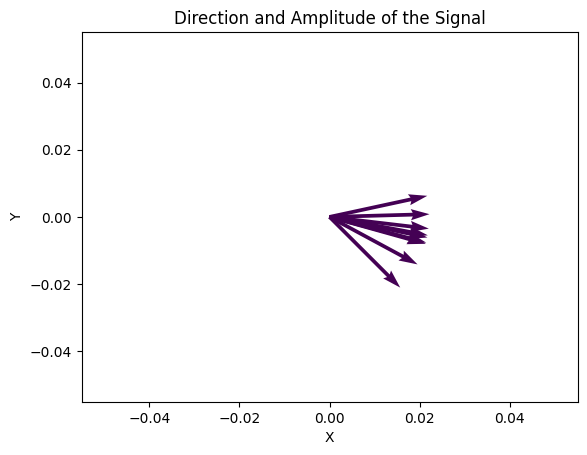

In [26]:
plt.quiver(np.zeros_like(directions), np.zeros_like(directions), np.cos(directions), np.sin(directions), amplitude_val, scale=1, scale_units='inches')
    
plt.title('Direction and Amplitude of the Signal')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


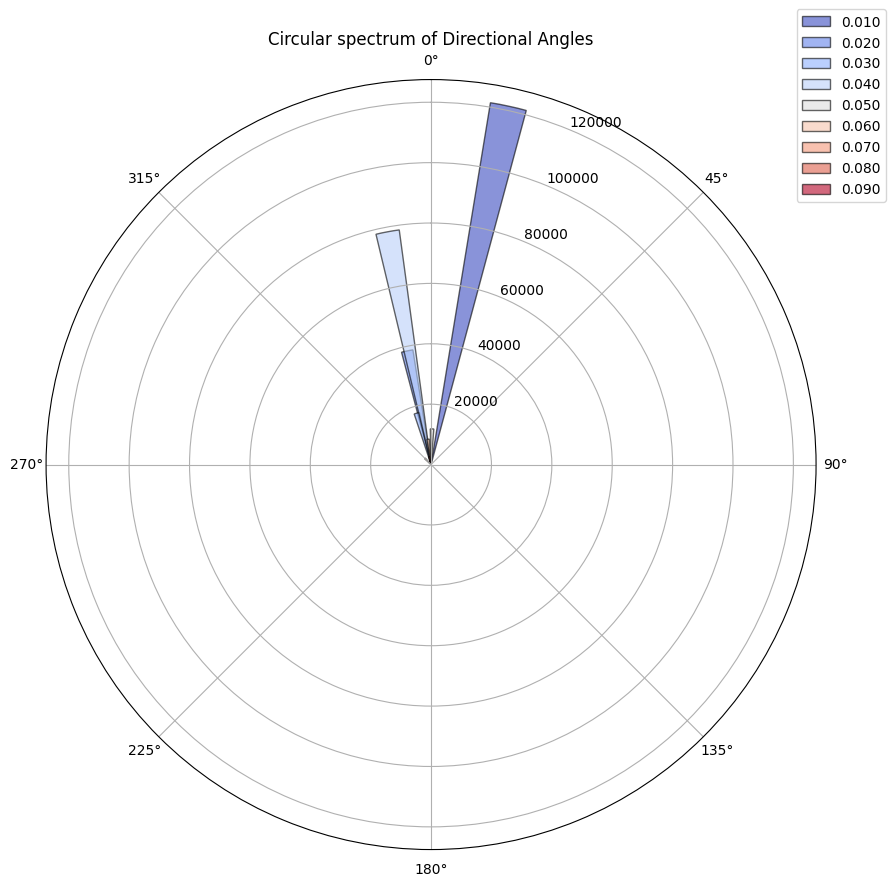

In [28]:
def visualize_results(all_directions, all_amplitudes, wavenumber_values):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(np.linspace(0, 1, len(wavenumber_values)))
    
    for i, wavenumber in enumerate(wavenumber_values):
        directions = [dirs[i] for dirs in all_directions if len(dirs) > i]
        amplitudes = [amps[i] for amps in all_amplitudes if len(amps) > i]
        
        # Convert directions to angles in radians
        angles = np.array(directions)
        
        # Plot the histogram
        ax.bar(angles, amplitudes, width=0.1, color=colors[i], alpha=0.6, edgecolor='k', label=f'{wavenumber:.3f}')
    
    ax.set_title('Circular spectrum of Directional Angles')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()


visualize_results(all_directions, all_amplitudes, wavenumber_values)